In [1]:
!pip install -q geopandas networkx

In [2]:
%config InlineBackend.figure_formats = ["svg"]
import base64
import io
import json
import requests

import pandas as pd; pd.set_option('display.max_rows', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

from shapely import Point

# Week 5: weapons flows

### Fetching SIPRI flow data

This is a case study in real-world data munging... [more here about the weird format]

In [3]:
raw_data = requests.post(
    "https://atbackend.sipri.org/api/p/trades/trade-register-csv/",
    json={"filters": []},
).json()

In [4]:
csv_lines = base64.b64decode(raw_data["bytes"]).decode("iso-8859-1").split("\n")
csv_lines[:15]

["Transfers of major conventional arms from All countries  to All countries . Deals with deliveries made for the year range 'Not specified' to 'Not specified' ",
 "A '?' in a column indicates uncertain data. The 'Number delivered' and the 'Year(s) of deliveries' refer only to deliveries in the selected year(s).",
 "An empty field for 'Number ordered' indicates that data is not yet available.",
 'SIPRI trend-indicator values (TIVs) are in millions.',
 "An empty field for 'SIPRI TIV for total order' indicates that data (on the number ordered and/or the TIV per unit) is not available.",
 "A '0' for 'SIPRI TIV of delivered weapons' indicates that the volume of deliveries is between 0 and 0.5 million SIPRI TIV; and an empty field indicates that no deliveries have been identified.",
 'Figures may not add up to stated totals due to the conventions of rounding.',
 'For the method used for the SIPRI TIV and explanations of the conventions; abbreviations and acronyms see <https://www.sipri.org/d

In [5]:
first_line_index = next(idx for idx, line in enumerate(csv_lines) if line.startswith("Recipient,"))
first_line_index

11

In [6]:
arms_df = pd.read_csv(io.StringIO("\n".join(csv_lines[first_line_index:])))
arms_df

,Recipient,Supplier,Year of order,,Number ordered,.1,Weapon designation,Weapon description,Number delivered,.2,Year(s) of delivery,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons
0,Afghanistan,Brazil,2017.0,NaN,6.0,NaN,EMB-314 Super Tucano,trainer/combat aircraft,6.0,?,2018,New,A-29B version; financed by USA; ordered via US...,4.50,27.0,27.0
1,Afghanistan,Russia,2004.0,NaN,6.0,NaN,aircraft engine,aircraft engine,6.0,NaN,2005,New,Klimov TV-3-117 turboshaft; spare engines for ...,0.50,3.0,3.0
2,Afghanistan,Soviet Union,1977.0,?,26.0,NaN,AI-25,turbofan,26.0,?,1977; 1978,New,For 26 L-39 trainer aircraft from Czechoslovak...,0.60,15.6,15.6
3,Afghanistan,Soviet Union,1988.0,?,2300.0,?,R-17 Elbrus,SSM,2300.0,?,1988; 1989; 1990; 1991,New,Mainly for use against Mujahideen rebel forces,1.25,2875.0,2875.0
4,Afghanistan,United Kingdom,2009.0,NaN,2.0,NaN,Mi-17,transport helicopter,2.0,NaN,2010,Second hand,Second-hand Mi-17 version bought by UK for 'Pr...,2.90,5.8,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29053,Zimbabwe,Russia,1998.0,?,6.0,NaN,Mi-24P/Mi-35P,combat helicopter,6.0,NaN,1999,Second hand,Second-hand; bought for use in DRC against reb...,3.60,21.6,21.6
29054,Zimbabwe,Italy,1967.0,?,20.0,?,Model-56 105mm,towed gun,20.0,?,1967,New,Supplier uncertain,0.45,9.0,9.0
29055,Zimbabwe,Soviet Union,1975.0,?,15.0,?,T-34-85,tank,15.0,?,1975,Second hand,Second-hand; supplier uncertain,0.38,5.7,5.7
29056,Zimbabwe,China,2004.0,?,5.0,?,Type-89/ZSD-89,APC,5.0,?,2004,New,ARV version,0.30,1.5,1.5


For more on the SIPRI TIV (trend indicator value), see the SIPRI fact sheet ["Measuring International Arms Transfers"](https://www.sipri.org/sites/default/files/files/FS/SIPRIFS1212.pdf).

In [7]:
arms_df.groupby(["Recipient", "Supplier", "Year of order"]).count()

Number ordered   .1  \
Recipient            Supplier           Year of order                           
ANC (South Africa)*  Soviet Union       1988.0         0               1    1   
Afghanistan          Belarus            2018.0         0               1    0   
                     Bosnia-Herzegovina 2009.0         0               1    0   
                                        2012.0         1               1    1   
                     Brazil             2013.0         0               1    0   
...                                                   ..             ...  ...   
unknown recipient(s) United States      1995.0         0               1    0   
                                        2010.0         0               1    1   
                                        2013.0         0               1    1   
                                        2018.0         2               2    2   
                                        2023.0         1               1    0   

                                                       Weapon designation  \
Recipient            Supplier           Year of order                       
ANC (South Africa)*  Soviet Union       1988.0                          1   
Afghanistan          Belarus            2018.0                          1   
                     Bosnia-Herzegovina 2009.0                          1   
                                        2012.0                          1   
                     Brazil             2013.0                          1   
...                                                                   ...   
unknown recipient(s) United States      1995.0                          1   
                                        2010.0                          1   
                                        2013.0                          1   
                                        2018.0                          2   
                                        2023.0                          2   

                                                       Weapon description  \
Recipient            Supplier           Year of order                       
ANC (South Africa)*  Soviet Union       1988.0                          1   
Afghanistan          Belarus            2018.0                          1   
                     Bosnia-Herzegovina 2009.0                          1   
                                        2012.0                          1   
                     Brazil             2013.0                          1   
...                                                                   ...   
unknown recipient(s) United States      1995.0                          1   
                                        2010.0                          1   
                                        2013.0                          1   
                                        2018.0                          2   
                                        2023.0                          2   

                                                       Number delivered   .2  \
Recipient            Supplier           Year of order                          
ANC (South Africa)*  Soviet Union       1988.0                        1    1   
Afghanistan          Belarus            2018.0                        1    0   
                     Bosnia-Herzegovina 2009.0                        1    1   
                                        2012.0                        1    0   
                     Brazil             2013.0                        1    1   
...                                                                 ...  ...   
unknown recipient(s) United States      1995.0                        1    0   
                                        2010.0                        1    1   
                                        2013.0                        1    1   
                                        2018.0                        2    2   
                                        

In [8]:
# arms_df[(arms_df["Weapon designation"] == "Mi-17") & (arms_df["Supplier"] != "Russia") & (arms_df["Supplier"] != "Soviet Union")]
arms_df[arms_df["status"] == "Second hand"]

,Recipient,Supplier,Year of order,,Number ordered,.1,Weapon designation,Weapon description,Number delivered,.2,Year(s) of delivery,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons
4,Afghanistan,United Kingdom,2009.0,NaN,2.0,NaN,Mi-17,transport helicopter,2.0,NaN,2010,Second hand,Second-hand Mi-17 version bought by UK for 'Pr...,2.90,5.8,5.8
7,Afghanistan,Soviet Union,1987.0,?,40.0,?,MiG-21MF,fighter aircraft,40.0,?,1987; 1988; 1989; 1990,Second hand,Second-hand; probably incl some MiG-21UM,4.28,171.2,171.2
11,Afghanistan,Soviet Union,1970.0,?,50.0,?,BRDM-1,reconnaissance AV,50.0,?,1970; 1971,Second hand,Probably second-hand,0.05,2.4,2.4
12,Afghanistan,Soviet Union,1979.0,?,250.0,?,BRDM-2,reconnaissance AV,250.0,?,1979; 1980; 1981; 1982; 1983; 1984; 1985; 1986...,Second hand,Probably second-hand,0.06,15.0,15.0
16,Afghanistan,Soviet Union,1989.0,?,40.0,?,MiG-21bis,fighter aircraft,40.0,?,1989; 1990,Second hand,Second-hand,5.00,200.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29049,Zimbabwe,Mozambique,1976.0,?,5.0,NaN,BN-2 Islander,light transport aircraft,5.0,?,1977,Second hand,Second-hand,0.24,1.2,1.2
29050,Zimbabwe,Kenya,1981.0,NaN,5.0,NaN,Hunter,FGA aircraft,5.0,NaN,1981,Second hand,Second-hand; sold via UK company; Hunter FGA-8...,1.60,8.0,8.0
29052,Zimbabwe,Ukraine,2000.0,?,1.0,?,An-12,transport aircraft,1.0,?,2001,Second hand,Second-hand,9.20,9.2,9.2
29053,Zimbabwe,Russia,1998.0,?,6.0,NaN,Mi-24P/Mi-35P,combat helicopter,6.0,NaN,1999,Second hand,Second-hand; bought for use in DRC against reb...,3.60,21.6,21.6


In [9]:
arms_df["Weapon designation"].value_counts()

Weapon designation
aircraft engine     417
vehicle engine      398
ship engine         379
Mi-17               239
M-113               225
                   ... 
F-14A Tomcat          1
Kharg                 1
Tigercat-2            1
Bandar Abbas          1
ATMOS M-46 130mm      1
Name: count, Length: 4074, dtype: int64

## Postprocessing: mapping actors to places

Visualizing the SIFRI dataset presents several problems:

* Recipients and suppliers are _usually_ countries, but this does not always hold. Notice that the dataset includes non-state actors (such as the [Houthi rebels](https://en.wikipedia.org/wiki/Houthis) or the [Mujahedin](https://en.wikipedia.org/wiki/Afghan_mujahideen)).
* This dataset goes back to the 1940s, so it references countries that no longer exist (such as [Biafra](https://en.wikipedia.org/wiki/Biafra) and [Yugoslavia](https://en.wikipedia.org/wiki/Yugoslavia)).
* There is some naming variation betwen the SIFRI dataset and the shapefile of capital cities we'll use for visualization. For instance, Ivory Coast and Cote d'Ivoire are two different names for the same country.

For visualization purposes, we'll map these special cases to the nearest equivalent contemporary states. For instance, we'll map South Vietnam to Vietnam; Saigon (the former capital of South Vietnam) is now Ho Chi Minh City (the current capital of Vietnam). We'll exclude flows to or from entities that do not clearly correspond to a single region (for instance, the United Nations).

In [10]:
capitals_map = {
    "ANC (South Africa)*": "South Africa",
    "Anti-Castro rebels (Cuba)*": "Cuba",
    "Amal (Lebanon)*": "Lebanon",
    "Armas (Guatemala)*": "Guatemala",
    "Contras (Nicaragua)*": "Nicaragua",
    "Darfur rebels (Sudan)*": "Sudan",
    "ELF (Ethiopia)*": "Ethiopia",
    "EPLF (Ethiopia)*": "Ethiopia",
    "FRELIMO (Portugal)*": "Portugal",
    "Haiti rebels*": "Haiti",
    "Hezbollah (Lebanon)*": "Lebanon",
    "Houthi rebels (Yemen)*": "Yemen",
    "Indonesia rebels*": "Indonesia",
    "Khmer Rouge (Cambodia)*": "Cambodia",
    "Kurdistan Regional Government (Iraq)*": "Iraq",
    "LF (Lebanon)*": "Lebanon",
    "LRA (Uganda)*": "Uganda",
    "LTTE (Sri Lanka)*": "Sri Lanka",
    "Libya GNC": "Libya",
    "Libya HoR*": "Libya",
    "Congo": "Congo (Brazzaville)",
    "DR Congo": "Congo (Kinshasa)",
    "MNLF (Philippines)*": "Philippines",
    "MPLA (Portugal)*": "Portugal",
    "MTA (Myanmar)*": "Myanmar",
    "Micronesia": "Federated States of Micronesia",
    "Mujahedin (Afghanistan)*": "Afghanistan",
    "NLA (Macedonia)*": "North Macedonia",
    "NTC (Libya)*": "Libya",
    "Northern Alliance (Afghanistan)*": "Afghanistan",
    "Northern Cyprus": "Cyprus",
    "PAIGC (Portugal)*": "Portugal",
    "PIJ (Israel/Palestine)*": "Israel",
    "PKK (Turkiye)*": "Turkey",
    "PLO (Israel)*": "Israel",
    "PRC (Israel/Palestine)*": "Israel",
    "Pathet Lao (Laos)*": "Laos",
    "Provisional IRA (UK)*": "United Kingdom",
    "RPF (Rwanda)*": "Rwanda",
    "RUF (Sierra Leone)*": "United Kingdom",
    "SLA (Lebanon)*": "Lebanon",
    "SNA (Somalia)*": "Somalia",
    "SPLA (Sudan)*": "Sudan",
    "Southern rebels (Yemen)*": "Yemen",
    "Syria rebels*": "Syria",
    "Turkiye": "Turkey",
    "UAE": "United Arab Emirates",
    "UIC (Somalia)*": "Somalia",
    "UNITA (Angola)*": "Angola",
    "Ukraine Rebels*": "Ukraine",
    "United States": "United States of America",
    "United Wa State (Myanmar)*": "Myanmar",
    "Viet Minh (France)*": "France",
    "Viet Nam": "Vietnam",
    "ZAPU (Zimbabwe)*": "Zimbabwe",
    "GUNT (Chad)*": "Chad",
    "FAN (Chad)*": "Chad",
    "FMLN (El Salvador)*": "El Salvador",
    "Gambia": "The Gambia",
    "Lebanon Palestinian rebels*": "Lebanon",
    "Cote d'Ivoire": "Ivory Coast",
    "Bahamas": "The Bahamas",
    "FNLA (Angola)*": "Angola",
    "Cabo Verde": "Cape Verde",
    "Timor-Leste": "East Timor",
    "Saint Vincent": "Saint Vincent and the Grenadines",
    "Guinea-Bissau": "Guinea Bissau",
    "South Vietnam": "Vietnam",  # Saigon is now Ho Chi Minh City
    "Viet Cong (South Vietnam)*": "Vietnam",
    "Hamas (Palestine)*": "Palestine",
    "Soviet Union": "Russia",
    "NATO**": "Belgium",  # NATO headquarters in Brussels
    'European Union**': "Belgium",  # EU headquarters in Brussels
    "OSCE**": "Austria",  # secretariat in Vienna
    "Yemen Arab Republic (North Yemen)": "Yemen",  # same capital as Yemen (Sanaa)
    "North Yemen": "Yemen",  # same capital as Yemen (Sanaa)
    "Czechoslovakia": "Czechia",  # same capital as the modern Czech Republic (Prague)
    "Yugoslavia": "Serbia",  # same capital as Serbia (Belgrade)
    "East Germany (GDR)": "Germany",  # for large-scale flow maps, approximate East Berlin with Berlin
    "Western Sahara": "Morocco",  # largely under Moroccan occupation,
}

exclude_flows = {
    "nan",
    "unknown rebel group*",
    "unknown recipient(s)",
    'unknown supplier(s)',
    "United Nations**",
    "Regional Security System**",
    "African Union**",
    '0.25',
    '3',
}


In [11]:
# (long, lat) coordinates for capitals of entities not included in the places shapefile.
# Several of these entities are countries that no longer exist.
extra_capitals = {  
    "Biafra": ("Enugu", 7.5139, 6.4483),  # 1967 capital (now part of Nigeria)
    "Bosnia-Herzegovina": ("Sarajevo", 18.4131, 43.8563),  
    "South Yemen": ("Aden", 45.0176, 12.7906),
    "Katanga": ("Lubumbashi", 27.5026, -11.6876),
    "South Sudan": ("Juba",  31.5825, 4.8539),
    "Palestine": ("East Jerusalem", 35.217018, 31.771959),
    "Aruba": ("Oranjestad", -70.0353, 12.5227),
}

In [12]:
extra_capitals_gdf = gpd.GeoDataFrame(
    [
        {
            "adm0name": entity,
            "name": capital,
            "longitude": long, 
            "latitude": lat,
            "geometry": Point(long, lat),
        }
        for entity, (capital, long, lat) in extra_capitals.items()
    ],
    crs="epsg:4326",
).set_index("adm0name")
extra_capitals_gdf

,name,longitude,latitude,geometry
adm0name,,,,
Biafra,Enugu,7.513900,6.448300,POINT (7.51390 6.44830)
Bosnia-Herzegovina,Sarajevo,18.413100,43.856300,POINT (18.41310 43.85630)
South Yemen,Aden,45.017600,12.790600,POINT (45.01760 12.79060)
Katanga,Lubumbashi,27.502600,-11.687600,POINT (27.50260 -11.68760)
South Sudan,Juba,31.582500,4.853900,POINT (31.58250 4.85390)
Palestine,East Jerusalem,35.217018,31.771959,POINT (35.21702 31.77196)
Aruba,Oranjestad,-70.035300,12.522700,POINT (-70.03530 12.52270)


In [13]:
places_gdf = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_populated_places_simple.zip")
capitals_gdf = places_gdf[places_gdf["adm0cap"] == 1].set_index("adm0name")
# force each nation to have exactly one capital
capitals_gdf = capitals_gdf[~capitals_gdf["name"].isin(["Sucre", "Yamoussoukro", "Bloemfontein", "Pretoria"])][["name", "latitude", "longitude", "geometry"]]
capitals_gdf = gpd.GeoDataFrame(pd.concat([capitals_gdf, extra_capitals_gdf]), crs="epsg:4326")

In [14]:
capitals_gdf.tail(20)

,name,latitude,longitude,geometry
adm0name,,,,
South Africa,Cape Town,-33.918065,18.433042,POINT (18.43304 -33.91807)
Russia,Moscow,55.754110,37.613577,POINT (37.61358 55.75411)
Mexico,Mexico City,19.444388,-99.132934,POINT (-99.13293 19.44439)
Italy,Rome,41.897902,12.481313,POINT (12.48131 41.89790)
China,Beijing,39.930838,116.386340,POINT (116.39420 39.90172)
Kenya,Nairobi,-1.281401,36.814711,POINT (36.81471 -1.28140)
Indonesia,Jakarta,-6.172472,106.827492,POINT (106.82749 -6.17247)
Colombia,Bogota,4.598369,-74.085290,POINT (-74.08529 4.59837)
Egypt,Cairo,30.051906,31.248022,POINT (31.24802 30.05191)


ideas:
* pick a protracted conflict (e.g. Israel–Palestine)
* pick a year or two
* analyze the immediate effects of the collapse of the USSR on arms flows
* analyze secondhand arms sales (in the context of the Cold War?) – how are arms recycled?
* analyze the popularity and regionality of a particular arm (e.g. the Mi-17) over time

## Introduction to graphs

In [15]:
flowmap_arms_df = arms_df[~arms_df["Supplier"].isin(exclude_flows) & ~arms_df["Recipient"].isin(exclude_flows)].rename(
    columns={
        "Year of order": "order_year",
        "Recipient": "recipient",
        "Supplier": "supplier",
        "SIPRI TIV for total order": "order_sipri_tiv"
    }
)
flowmap_arms_df["order_year"] = flowmap_arms_df["order_year"].astype(int)
flowmap_arms_df = flowmap_arms_df[flowmap_arms_df["order_year"] >= 1950]

In [16]:
orders_by_year_df = flowmap_arms_df.groupby(["order_year", "recipient", "supplier"]).sum()["order_sipri_tiv"]
orders_by_year_df

order_year  recipient  supplier      
1950        Argentina  United States     135.51
            Australia  United Kingdom    337.68
                       United States       0.60
            Belgium    United Kingdom     78.00
                       United States     756.12
                                          ...  
2023        Uruguay    Spain               0.00
                       United States      12.72
            Viet Nam   India              30.00
            Zambia     United States      20.80
            Zimbabwe   China              20.40
Name: order_sipri_tiv, Length: 15215, dtype: float64

Let's visualize arms flows to and from the U.S. in a particular year by constructing a graph.

In [17]:
year = 1980
country = "United States"

In [18]:
filtered_orders_df = orders_by_year_df[year].reset_index()
filtered_orders_df = filtered_orders_df[
    (filtered_orders_df["recipient"] == "United States")
    | (filtered_orders_df["supplier"] == "United States")
]
filtered_orders_df.head(10)

,recipient,supplier,order_sipri_tiv
13,Argentina,United States,46.55
17,Australia,United States,481.60
18,Austria,United States,105.00
21,Bangladesh,United States,14.80
25,Bolivia,United States,5.64
31,Brunei,United States,1.40
36,Canada,United States,4310.26
44,Chile,United States,52.85
49,Colombia,United States,42.92
52,Costa Rica,United States,0.44


In [19]:
orders_graph = nx.DiGraph()

for _, row in filtered_orders_df.iterrows():
    orders_graph.add_edge(
        row.supplier,
        row.recipient,
        weight=row.order_sipri_tiv,
    )

In [20]:
orders_graph.edges

OutEdgeView([('United States', 'Argentina'), ('United States', 'Australia'), ('United States', 'Austria'), ('United States', 'Bangladesh'), ('United States', 'Bolivia'), ('United States', 'Brunei'), ('United States', 'Canada'), ('United States', 'Chile'), ('United States', 'Colombia'), ('United States', 'Costa Rica'), ('United States', 'Denmark'), ('United States', 'Dominican Republic'), ('United States', 'Ecuador'), ('United States', 'Egypt'), ('United States', 'El Salvador'), ('United States', 'Finland'), ('United States', 'Gabon'), ('United States', 'Germany'), ('United States', 'Greece'), ('United States', 'Guatemala'), ('United States', 'Honduras'), ('United States', 'Indonesia'), ('United States', 'Ireland'), ('United States', 'Israel'), ('United States', 'Italy'), ('United States', 'Jamaica'), ('United States', 'Japan'), ('United States', 'Jordan'), ('United States', 'Kenya'), ('United States', 'Malaysia'), ('United States', 'Mauritania'), ('United States', 'Morocco'), ('United 

In [21]:
def cast_point(p):
    return (p.xy[0][0], p.xy[1][0])

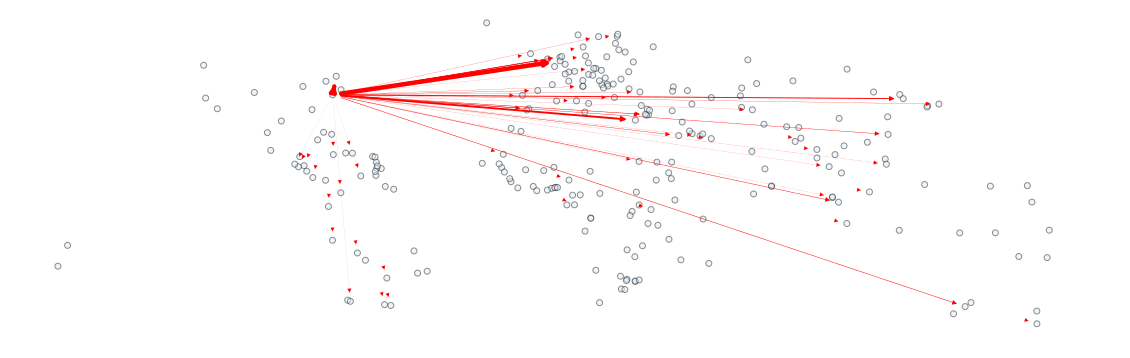

In [22]:
fig, ax = plt.subplots(figsize=(20, 40))
ax.axis("off")
places_gdf.plot(ax=ax, edgecolor="0.1", linewidth=1, color="#e1f1fd", alpha=0.5)

pos = dict(capitals_gdf.geometry)

for edge in orders_graph.edges(data='weight'):
    if edge[0] in exclude_flows or edge[1] in exclude_flows:
        continue

    edge_pos = {
        edge[0]: cast_point(pos[capitals_map.get(edge[0], edge[0])]),
        edge[1]: cast_point(pos[capitals_map.get(edge[1], edge[1])]),
    }
    nx.draw_networkx_edges(orders_graph, edge_pos, edgelist=[edge], width=0.001 * edge[2], ax=ax, edge_color="red")

## Advanced flow visualizations with FlowmapBlue

In [23]:
#!pip install "git+https://github.com/PUBPOL-2130/notebooks#egg=pubpol2130&subdirectory=lib"

In [24]:
from pubpol2130 import google_sheets_credentials, generate_flow_sheet

In [25]:
flowmap_locations_df = pd.DataFrame(
    [
        {
            "id": loc,
            "name": loc,
            "lat": capitals_gdf.loc[capitals_map.get(loc, loc), "latitude"],
            "lon": capitals_gdf.loc[capitals_map.get(loc, loc), "longitude"],
        }
        for loc in set(flowmap_arms_df["supplier"]) | set(flowmap_arms_df["recipient"])
    ]
)
flowmap_locations_df.head(5)

,id,name,lat,lon
0,Romania,Romania,44.435318,26.098001
1,Qatar,Qatar,25.286556,51.532968
2,Libya GNC,Libya GNC,32.892500,13.180012
3,Russia,Russia,55.754110,37.613577
4,Namibia,Namibia,-22.570006,17.083546


**(TODO: instructions for an API key here?)**

In [26]:
sheet_creds = google_sheets_credentials()

In [30]:
flow_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=flowmap_locations_df,
    created_by_name="",  # YOUR NAME HERE
    created_by_email="", # YOUR EMAIL HERE
    data_source_name="SIPRI Arms Transfers Database",
    data_source_url="https://www.sipri.org/databases/armstransfers",
    incoming_tooltip="Inbound arms transfers (TIV)",
    outgoing_tooltip="Outbound arms transfers (TIV)",
    flow_tooltip="Arms transfer (TIV)",
    total_unit="TIVs",
    sheet_title="PUBPOL 2130: SIPRI arms transfers (orders over time)",
    flow_title="SIPRI Arms Transfers Database: orders over time",
    flows={
        f"Year: {year}": year_df.reset_index().rename(columns={
            "supplier": "origin",
            "recipient": "dest",
            "order_sipri_tiv": "count",
        })
        for year, year_df in orders_by_year_df.groupby(level=0)
        if year < 1955
    }
)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.77s/it]


In [28]:
print(flow_sheet.url)

https://docs.google.com/spreadsheets/d/1FZAD8wrVSpfgAEmzrWBzjTs-YdpdPx1_iXJ13YEjhHU


In [29]:
print(f"https://www.flowmap.blue/{flow_sheet.url.split('/')[-1]}")

https://www.flowmap.blue/1FZAD8wrVSpfgAEmzrWBzjTs-YdpdPx1_iXJ13YEjhHU
